Network Architecture


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Oct 15 2023 15:12:16

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

Building Cortical Thalamic Network


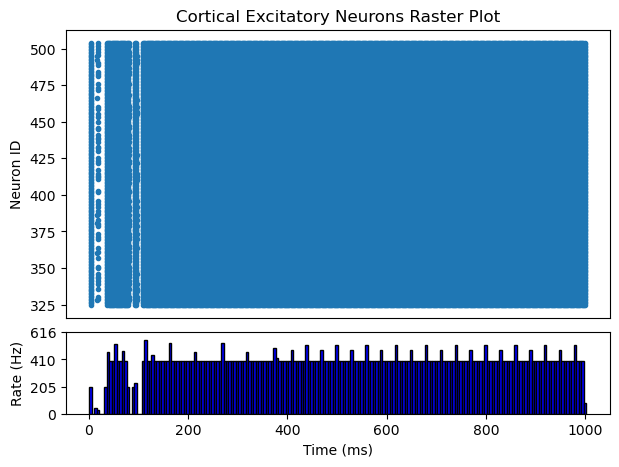

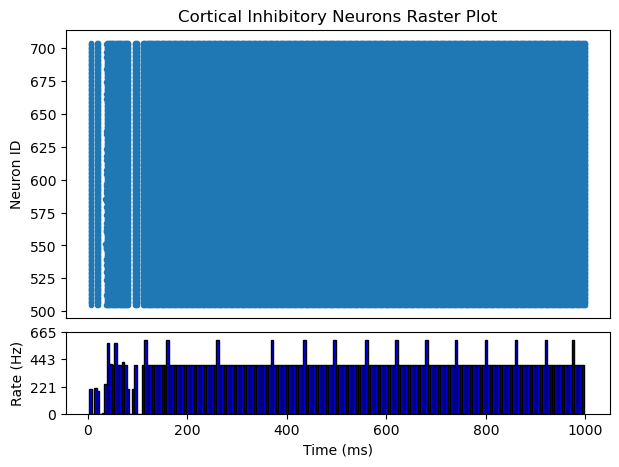

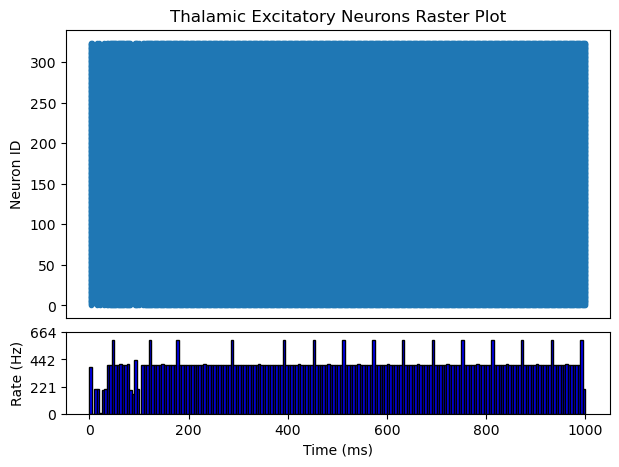

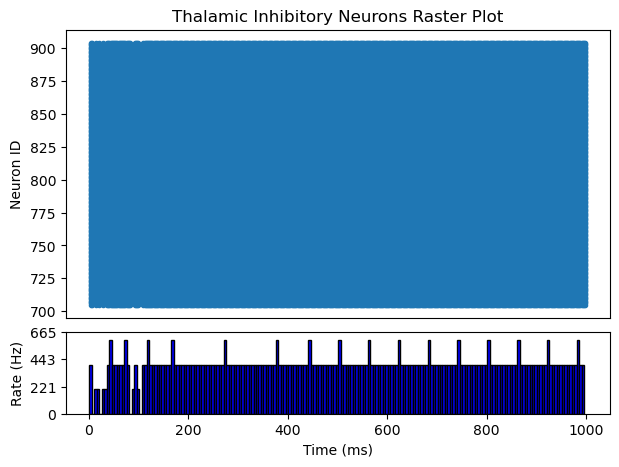

TypeError: from_device() got an unexpected keyword argument 'hist'

In [1]:
import nest
import sys
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import time
import random
import pylab  #interface de alto nível para matplotlib
import scipy.io as sio # para operações relacionadas a entrada/saída
        
import nest.voltage_trace
import nest.raster_plot
    
nest.set_verbosity("M_WARNING")
nest.ResetKernel()
startbuild = time.time()
#
# Parameter assumed by the network
#Definição de constantes
N_CLASSES = 10
N_RANKS = 3
N_TEST = 250

startTime = time.time()
simtime = 1000.0
#============================= PRE PROCESSING ======================================================================
#
# Pré-processamento do conjunto de dados MNIST.
# são arrays que contêm características (provavelmente extraídas das imagens) 
# do conjunto de treinamento (fn_train) e teste (fn_test), respectivamente.
# "labels_train0" e "labels_test" contêm os rótulos correspondentes 
# (números de 0 a 9) para as imagens no conjunto de treinamento e teste 
#
fn_train = 'mnist_training_features_0.9_14.npy'
feat_arr_train0 = np.load(fn_train)
label_fn_train = 'mnist_training_labels_0.9_14.npy'
labels_train0 = np.load(label_fn_train)
fn_test = 'mnist_test_features_0.9_14.npy'
feat_arr_test = np.load(fn_test)
label_fn_test = 'mnist_test_labels_0.9_14.npy'
labels_test = np.load(label_fn_test)

# Organização dos dados de treinamento por classes
# "feat_train_class" e "label_train_class" são listas que armazenam, respectivamente, 
# características e rótulos agrupados por classe.
feat_train_class=[[] for i in range(N_CLASSES)] # empty 2d list (N_CLASSES x N)
label_train_class=[[] for i in range(N_CLASSES)]
for i in range(len(labels_train0)):
    i_class = labels_train0[i]
    feat_train_class[i_class].append(feat_arr_train0[i])
    label_train_class[i_class].append(i_class)

# Seleção de um subconjunto de dados.
# Um subconjunto de dados (feat_red e labels_red) é selecionado a partir das listas organizadas por classe.
# A seleção é feita com base nas constantes N_CLASSES e N_RANKS.
feat_red = [feat_train_class[i][j] for i in range(N_CLASSES)
            for j in range(0*N_RANKS,(0+1)*N_RANKS)]
labels_red = [label_train_class[i][j] for i in range(N_CLASSES)
              for j in range(0*N_RANKS,(0+1)*N_RANKS)]

# Preparação de dados e ajuste de sementes aleatórias
rand = np.random.RandomState(12345)

# As características (feat_red) e rótulos (labels_red) 
# são convertidos em arrays NumPy para facilitar o manuseio.
feat_arr_train = np.asarray(feat_red)
labels_train = np.asarray(labels_red)

# Os rótulos são convertidos para o tipo de dado inteiro. 
# Isso é comum para garantir que os rótulos sejam interpretados corretamente durante o treinamento 
# ou simulação.
labels_train=labels_train.astype(int)
labels_test=labels_test.astype(int)

# PARAMETERS ======================================================================================================

# Noises
noiseThEx = 30000.0
noiseOut = 10000.0
noiseCxEx = 2000.0 
noiseCxIn = 10000.0
noiseThExRecog = noiseThEx
noiseCxExSleep = 680.

# Weights
W_noiseThEx = 8.0
W_noiseCxEx = 15.0
W_noiseOut = 1.4
W_noiseCxIn = 5.0

W0_CxExThEx = 1.
W0_ThExCxEx = 1.
W0_CxExOut = 0.0001
W0_CxExCxEx = 4.

Wmax_ThExCxEx = 5.50
Wmax_CxExThEx = 135.
Wmax_CxExOut = 154.0
Wmax_CxExCxEx = 150.0

W_CxExCxIn = 60.0
W_CxInCxEx = -4.
W_CxInCxEx_retrieval = -4. 
W_CxInCxIn = -1.
W_CxInCxExSleep = -.7
W_ThExThIn = 10.0
W_ThInThEx = -1.0

# STDP Parameters
muMinus = 1.
muPlus =  1.
alpha = 1.
alphaSleep = 5.
bSleep = 80.

lambda_ThExCxEx = 0.03
lambda_CxExThEx = .08
lambda_CxExOut = .0
lambda_CxExCxEx = 0.09

lambda_ThExCxExSleep = 0.0
lambda_CxExOutSleep = 0.0
lambda_CxExCxExSleep = .000003

# Simulations time
tTrain = 500.0
tPause = 400.0
tCheck = 200.0
tSleep = 600000.

inputSize = 324     # Number of excitatory thalamic neurons
nClasses = N_CLASSES   # Classes division for training task

trainDigit=feat_arr_train
teachOut=labels_train
nTrain = 9

testDigit=feat_arr_train
testOut = labels_train
nTest = 9

#   Number of neuron populations
gCxEx = 20                          # Group of cortical excitatory neurons
CxExNeuron = gCxEx*nTrain         # number of cortical excitatory neurons
CxInNeuron = 200
ThExNeuron = inputSize
ThInNeuron = 200
nOut = nClasses

#   Input patterns trainPattern and testPattern are arrays receiving trainDigit and testDigit respectively
trainPattern = [[0 for i in range(ThExNeuron)] for j in range(nTrain)] 
for i in range(inputSize):
    for iTrain in range(nTrain):
        trainPattern[iTrain][i] = trainDigit[iTrain][i]

testPattern = [[0 for i in range(ThExNeuron)] for j in range(nTest)]
for i in range(inputSize):
    for iTest in range(nTest):
        testPattern[iTest][i] = testDigit[iTest][i]
#
# Array store the spike populations
nSpikesThEx = [0]*ThExNeuron
cumSpikesThEx = [0]*ThExNeuron    # Cumulative spikes storing of ThEx
nSpikesCxEx = [0]*CxExNeuron
cumSpikesCxEx = [0]*CxExNeuron
nSpikesCxIn = [0]*CxInNeuron
cumSpikesCxIn = [0]*CxInNeuron
nSpikesOut = [0]*nOut
cumSpikesOut = [0]*nOut
nSpikesThIn = [0]*ThInNeuron
cumSpikesThIn = [0]*ThInNeuron

#   Neuron parameters -- first run
vPeak = nest.GetDefaults('aeif_cond_alpha')['V_th']+5*nest.GetDefaults('aeif_cond_alpha')['Delta_T']
b = 0.01
t_ref = 2.0
neuronParams = {'V_peak': vPeak, 'b': b, 't_ref': t_ref}
#
print("Building Cortical Thalamic Network")
#   Creating populations
NeuronsThEx = nest.Create("aeif_cond_alpha", ThExNeuron)    # Thalamic excit pop
NeuronsCxEx = nest.Create("aeif_cond_alpha", CxExNeuron)    # Cortical excit pop
NeuronsCxIn = nest.Create("aeif_cond_alpha", CxInNeuron)    # cortical inhib pop
NeuronsThIn = nest.Create("aeif_cond_alpha", ThInNeuron)    # Thalamic inhib pop
NeuronsOut = nest.Create("aeif_cond_alpha", nOut)           # Output neurons - Classes
#    
nest.SetStatus(NeuronsThEx, params = neuronParams)
nest.SetStatus(NeuronsCxEx, params = neuronParams)
nest.SetStatus(NeuronsCxIn, params = neuronParams)
nest.SetStatus(NeuronsThIn, params = neuronParams)
nest.SetStatus(NeuronsOut, params = neuronParams)
#
# Input noise on the excit thalamic pop
ThExNoise = nest.Create("poisson_generator", {"rate": noiseThEx})
synDictNoiseThEx = {"weight": W_noiseThEx, "delay": 1.0}
nest.Connect(ThExNoise, NeuronsThEx, syn_spec=synDictNoiseThEx)
#
# Trainning noise on the excit cortical pop
CxExNoise = nest.Create("poisson_generator", {'rate': noiseCxEx}) 
synDictNoiseCxEx = {"weight": W_noiseCxEx, "delay": 1.0}
nest.Connect(CxExNoise, NeuronsCxEx, syn_spec=synDictNoiseCxEx)
#
# Building train exc neuron groups
trainTargetCxEx = [[0 for i in range(gCxEx)] for j in range(nTrain)]
tgt=range(gCxEx)
for iTrain in range(nTrain):
    for i_g in range(gCxEx):
        i = iTrain*gCxEx + i_g
        trainTargetCxEx[iTrain][i_g]=i
#        
# teaching output noise
OutNoise = nest.Create("poisson_generator", {"rate": noiseOut})
synDictNoiseOut = {"weight": W_noiseOut, "delay":1.0} 
nest.Connect(OutNoise, NeuronsOut, syn_spec=synDictNoiseOut)
#
# Spike detectors for inhibitory thalamic pop
SpikeDetecThIn = nest.Create("spike_recorder")
nest.Connect(NeuronsThIn, SpikeDetecThIn)

#=========== STDP synapses ===================================================================================================================== 
#
# STDP from excitatory thalamic neurons to excitatory cortical neurons
synDictThExCxEx = {"synapse_model" : "stdp_synapse", "lambda": lambda_ThExCxEx, "weight":W0_ThExCxEx, "Wmax": Wmax_ThExCxEx, "delay":1.0}
conn_dict = {'rule': 'pairwise_bernoulli', 'p': 1.0}
nest.Connect(NeuronsThEx, NeuronsCxEx, conn_dict, syn_spec=synDictThExCxEx)
#
# STDP from excitatory cortical neurons to excitatory thalamic neurons 
synDictCxExThEx = {"synapse_model" : "stdp_synapse", "lambda": lambda_CxExThEx, "weight":W0_CxExThEx,
                   "Wmax":Wmax_CxExThEx, "delay":1.0}
nest.Connect(NeuronsCxEx, NeuronsThEx, "all_to_all", syn_spec=synDictCxExThEx)
#
# STDP from excitatory cortical neurons to output 
synDictCxExOut = {"synapse_model" : "stdp_synapse", "lambda": lambda_CxExOut, "weight":W0_CxExOut, 
                  "Wmax":Wmax_CxExOut, "delay":1.0}
nest.Connect(NeuronsCxEx, NeuronsOut, "all_to_all", syn_spec=synDictCxExOut)
#
# STDP from excitatory to excitatory connections
synDictCxExCxEx = {"synapse_model" : "stdp_synapse", "lambda": lambda_CxExCxEx, 
                   "weight": W0_CxExCxEx, "Wmax":Wmax_CxExCxEx}
nest.Connect(NeuronsCxEx, NeuronsCxEx, conn_spec="all_to_all" , syn_spec=synDictCxExCxEx)

#===================================================================================================================================================

# From excitatory to inhibitory connections
synDictCxExCxIn = {"weight": W_CxExCxIn, "delay":1.0}
nest.Connect(NeuronsCxEx, NeuronsCxIn, conn_spec="all_to_all", syn_spec=synDictCxExCxIn)

# From inhibitory to excitatory connections
synDictCxInCxEx = {"weight": W_CxInCxEx, "delay":1.0}
nest.Connect(NeuronsCxIn, NeuronsCxEx, conn_spec="all_to_all", syn_spec=synDictCxInCxEx)

# From inhibitory to inhibitory
synDictCxInCxIn = {"weight": W_CxInCxIn, "delay":1.0}
nest.Connect(NeuronsCxIn, NeuronsCxIn, conn_spec="all_to_all", syn_spec=synDictCxInCxIn)

# From excitatory thalamical to inhibitory thalamical connections
synDictThExThIn = {"weight": W_ThExThIn, "delay":1.0}
nest.Connect(NeuronsThEx, NeuronsThIn, conn_spec="all_to_all", syn_spec=synDictThExThIn)

# From inhibitory thalamical to excitatory thalamocal connections
synDictThInThEx = {"weight": W_ThInThEx, "delay":1.0}
nest.Connect(NeuronsThIn, NeuronsThEx, conn_spec="all_to_all", syn_spec=synDictThInThEx)

# inhibitory noise
CxInNoise = nest.Create("poisson_generator", {"rate": noiseCxIn})
synDictNoiseCxIn = {"weight": W_noiseCxIn, "delay":1.0}
nest.Connect(CxInNoise, NeuronsCxIn, syn_spec=synDictNoiseCxIn)

# Spike detectors for excitatory thalamical pop
SpikeDetecThEx = nest.Create("spike_recorder")
nest.Connect(NeuronsThEx, SpikeDetecThEx)

# Spike detectors for excitatory cortical pop
SpikeDetecCxEx = nest.Create("spike_recorder")
nest.Connect(NeuronsCxEx, SpikeDetecCxEx)

# Spike detectors for inhibitory neurons
SpikeDetecCxIn = nest.Create("spike_recorder")
nest.Connect(NeuronsCxIn, SpikeDetecCxIn)

# Spike detectors for output
SpikeDetecOut = nest.Create("spike_recorder")
nest.Connect(NeuronsOut, SpikeDetecOut)

nest.Simulate(simtime)
#================================ TRAINING ======================================================================================= 




#=============================== PLOTS =================================================================================


# Plot da rasterização para as populações de neurônios excitatórios corticais
nest.raster_plot.from_device(SpikeDetecCxEx, title='Cortical Excitatory Neurons Raster Plot', hist=True)
plt.show()

# Plot da rasterização para as populações de neurônios inibitórios corticais
nest.raster_plot.from_device(SpikeDetecCxIn, title='Cortical Inhibitory Neurons Raster Plot', hist=True)
plt.show()

# Plot da rasterização para as populações de neurônios excitatórios talâmicos
nest.raster_plot.from_device(SpikeDetecThEx, title='Thalamic Excitatory Neurons Raster Plot', hist=True)
plt.show()

# Plot da rasterização para as populações de neurônios inibitórios talâmicos
nest.raster_plot.from_device(SpikeDetecThIn, title='Thalamic Inhibitory Neurons Raster Plot', hist=True)
plt.show()

# Plot da rasterização para as populações de neurônios de saída
#nest.raster_plot.from_device(SpikeDetecOut, title='Output Neurons Raster Plot', hist=True)
#plt.show()
#
print("Done!")
#

In [7]:
#nest.GetDefaults('spike_recorder')

In [4]:
#nest.GetDefaults("aeif_cond_alpha")

In [7]:
#nest.voltage_trace.from_device?

In [3]:
#nest.SetStatus?